<a href="https://colab.research.google.com/github/HirunaD/LangChain/blob/main/10_LLM_Evaluation_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Evaluate RAG Applications withh RAGAS**

In [ ]:
# Install the necessary packages
!pip install langchain==0.1.17
!pip install langchain-openai==0.0.7
!pip install langchain-chroma -q
!pip install langchain-community==0.0.11
!pip install langsmith==0.0.41
!pip install ragas==0.1.0
!pip install datasets==2.16.1
!pip install pypdf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.0.38 requires langchain-core<0.2.0,>=0.1.52, but you have langchain-core 0.3.69 which is incompatible.
langchain-community 0.0.38 requires langsmith<0.2.0,>=0.1.0, but you have langsmith 0.4.6 which is incompatible.
langchain-text-splitters 0.0.2 requires langchain-core<0.3,>=0.1.28, but you have langchain-core 0.3.69 which is incompatible.
langchain-openai 0.0.7 requires langchain-core<0.2.0,>=0.1.26, but you have langchain-core 0.3.69 which is incompatible.
langchain 0.1.17 requires langchain-core<0.2.0,>=0.1.48, but you have langchain-core 0.3.69 which is incompatible.
langchain 0.1.17 requires langsmith<0.2.0,>=0.1.17, but you have langsmith 0.4.6 which is incompatible.
  Using cached langchain_community-0.0.11-py3-none-any.whl.metadata (7.3 kB)
  Using cached langchain_core-0.1.53-py3-no

In [ ]:
import os
from google.colab import userdata

import warnings
warnings.filterwarnings('ignore')

**Initialize OpenAI LLM**

In [ ]:
from langchain_openai import ChatOpenAI

# Set OpenAI API key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-4.1-nano",
    temperature=0
)

**Initialize Embedding Model**

In [ ]:
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

**Load PDF Document**

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

# Load the PDF document
file_path = "/content/codeprolk.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

In [ ]:
len(docs)

4

**Split Documents into Chunks**

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)

# Split the documents into chunks
splits = text_splitter.split_documents(docs)

In [ ]:
len(splits)

20

**Create Vector Store and Retriever**

In [ ]:
from uuid import uuid4
from langchain_chroma import Chroma

# ✅ Generate unique IDs for each document
ids = [str(uuid4()) for _ in splits]

# ✅ Create the vectorstore with explicitly passed IDs
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embedding_model,
    ids=ids
)

In [ ]:
# Create a retriever from the vector store
retriever = vectorstore.as_retriever(search_kwargs={"k":2})

**Define Prompt Template**

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

# Define a message template for t he chatbot
message = """
Answer this question using the provided context only.

{question}

Context:
{context}
"""

# Create the prompt template from the message
prompt = ChatPromptTemplate.from_messages([("human", message),])

**Create Retrieval-Augmented Generation (RAG) Chain**

In [ ]:
from langchain.schema.output_parser import StrOutputParser

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

**Invoke RAG Chain with Example Questions**

In [ ]:
response = chain.invoke("who is codeprolk")
print(response)

CodePRO LK is a dynamic educational platform that offers a diverse range of technology-related courses in Sinhala, aimed at empowering Sri Lankans with skills in programming, data science, and machine learning. It was founded by Dinesh Piyasamara during the COVID-19 pandemic.


**Evaluate RAG System**

In [ ]:
import pandas as pd
test_data = pd.read_csv("/content/test_data.csv")
test_data

,question,answer
0,what is codeprolk,CodePRO LK is a dynamic educational platform ...
1,what is the main vision of them,To assist talented Sri Lankans in reaching th...
2,what is the mission of codeprolk,To produce high-quality tech courses and arti...
3,What are the courses they offer,CodeProLK offers courses like Python GUI with...
4,These courses are for which nationality,CodeProLK's courses are designed specifically...
5,what are the popular videos in codeprolk youtu...,It features popular videos like Python Basics...


In [32]:
questions = test_data["question"].to_list()
ground_truth = test_data["answer"].to_list()

In [33]:
questions

['what is codeprolk',
 'what is the main vision of them',
 'what is the mission of codeprolk',
 'What are the courses they offer',
 'These courses are for which nationality',
 'what are the popular videos in codeprolk youtube channel']

In [34]:
ground_truth

[' CodePRO LK is a dynamic educational platform that offers a diverse range of technology-related courses in Sinhala',
 ' To assist talented Sri Lankans in reaching the international market by providing a solid foundation in technology',
 ' To produce high-quality tech courses and articles that enhance the knowledge base of both students and professionals in the local community',
 ' CodeProLK offers courses like Python GUI with Tkinter,  Machine Learning Projects,  and Data Structures and Algorithms',
 " CodeProLK's courses are designed specifically for Sri Lankans  as they are all offered in Sinhala",
 ' It features popular videos like Python Basics,  Introduction to Machine Learning,  and Data Structures Explained']

In [42]:
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

In [43]:
for query in questions:
  data["question"].append(query)
  data["answer"].append(chain.invoke(query))
  data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

In [44]:
data

{'question': ['what is codeprolk',
  'what is the main vision of them',
  'what is the mission of codeprolk',
  'What are the courses they offer',
  'These courses are for which nationality',
  'what are the popular videos in codeprolk youtube channel'],
 'answer': ['CodePRO LK is a dynamic educational platform that offers a diverse range of technology-related courses in Sinhala, aimed at empowering Sri Lankans with skills in programming, data science, and machine learning.',
  'The main vision is to assist talented Sri Lankans in reaching the international market by providing a solid foundation in technology.',
  'The mission of CodePRO LK is to empower Sri Lankans with the skills and knowledge needed to succeed in the global tech industry.',
  'The provided context mentions a key course titled "Python GUI – Tkinter." However, it does not list any additional specific courses. Therefore, based on the available information, the courses offered include at least the "Python GUI – Tkinter"

In [45]:
from datasets import Dataset

dataset = Dataset.from_dict(data)

In [46]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 6
})

In [47]:
dataset[0]

{'question': 'what is codeprolk',
 'answer': 'CodePRO LK is a dynamic educational platform that offers a diverse range of technology-related courses in Sinhala, aimed at empowering Sri Lankans with skills in programming, data science, and machine learning.',
 'contexts': ['Introduction to CodePRO LK \nCodePRO LK is a dynamic educational platform that offers a diverse range of technology-\nrelated courses in Sinhala, aimed at empowering Sri Lankans with valuable skills in \nprogramming, data science, and machine learning. Founded by Dinesh Piyasamara during the \nCOVID-19 pandemic, CodePRO LK addresses the growing need for accessible, high-quality',
  'Community Engagement and Events \nCodePRO LK is committed to strengthening its community through regular engagement \nactivities such as webinars, live coding sessions, hackathons, and tech talks. These events \nprovide valuable networking opportunities and practical experience, fostering a supportive and \ncollaborative learning environm

In [48]:
from ragas.metrics import context_precision, context_recall, answer_relevancy, faithfulness
from ragas import evaluate

result = evaluate(
    dataset = dataset,
    metrics = [
        context_precision,
        context_recall,
        answer_relevancy,
        faithfulness,
    ],
)

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

In [49]:
result

{'context_precision': 0.8333, 'context_recall': 0.5000, 'answer_relevancy': 0.7117, 'faithfulness': 1.0000}

In [50]:
results = result.to_pandas()
results

,question,answer,contexts,ground_truth,context_precision,context_recall,answer_relevancy,faithfulness
0,what is codeprolk,CodePRO LK is a dynamic educational platform t...,[Introduction to CodePRO LK \nCodePRO LK is a ...,CodePRO LK is a dynamic educational platform ...,1.0,1.0,0.835472,1.0
1,what is the main vision of them,The main vision is to assist talented Sri Lank...,"[to thrive in a digitally-driven world, all th...",To assist talented Sri Lankans in reaching th...,1.0,1.0,0.844882,1.0
2,what is the mission of codeprolk,The mission of CodePRO LK is to empower Sri La...,[Conclusion \nCodePRO LK continues to be a bea...,To produce high-quality tech courses and arti...,1.0,0.0,0.925634,1.0
3,What are the courses they offer,The provided context mentions a key course tit...,[Learning Experience \nCourse Structure \nEach...,CodeProLK offers courses like Python GUI with...,0.5,0.0,0.844108,1.0
4,These courses are for which nationality,These courses are for Sri Lankans.,[Course Offerings \nVariety and Accessibility ...,CodeProLK's courses are designed specifically...,1.0,1.0,0.819869,1.0
5,what are the popular videos in codeprolk youtu...,The provided context does not specify which vi...,[Community Engagement \nThe YouTube channel ha...,It features popular videos like Python Basics...,0.5,0.0,0.000000,1.0


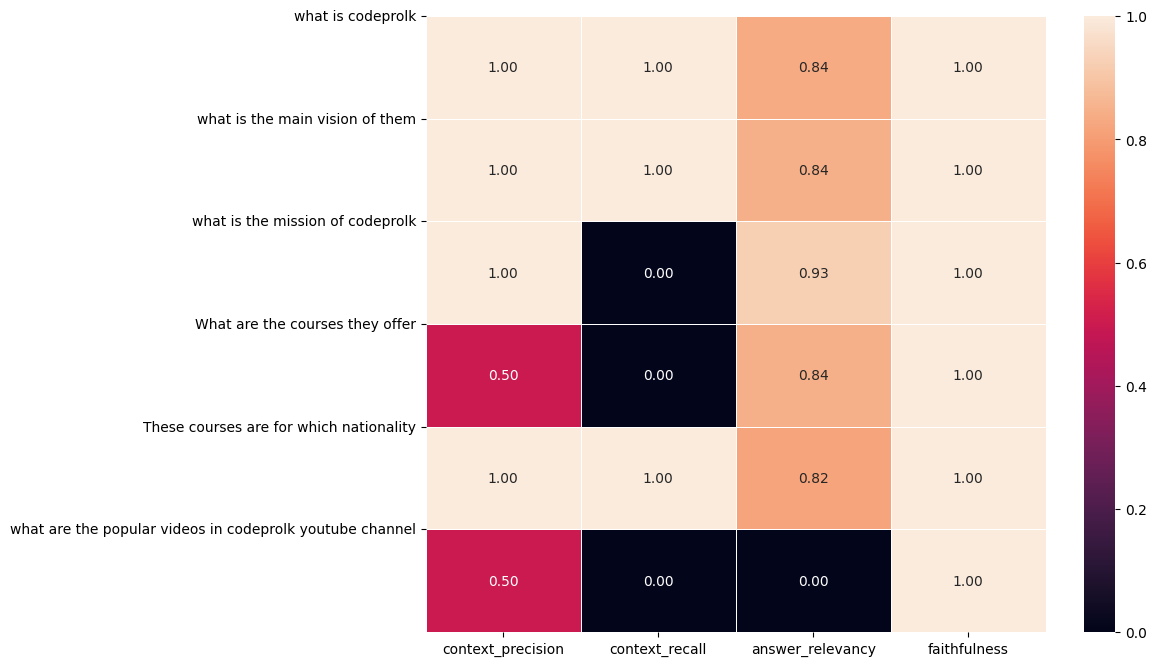

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = results[['context_precision', 'context_recall', 'answer_relevancy', 'faithfulness']]

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', linewidths=.5)

plt.yticks(ticks=range(len(results['question'])), labels=results['question'], rotation=0)

plt.show()